In this notebook we experiment with **PyMC3** which is a probabilistic programming library

We perform linear regression from the Bayesian inference perspective by putting priors ontop of the linear regression models. Specifically, we have

$$Y \sim \cal{N}(\mu, \sigma^2)$$
$$\mu = \alpha + \beta_1X_1 + \beta_2X_2$$

where $\alpha$ is the intercept and $\beta_i$ is the coefficents for covariates $X_i$

We specify priors as follow:

$$\alpha \sim \cal{N}(0,100)$$
$$\beta_i \sim \cal{N}(0,100)$$
$$\sigma \sim |\cal{N}(0,1)|$$

We choose a half-normal distribution as prior for $\sigma$ (normal distribution bounded at zero), since $\sigma \geq 0$

In [2]:
%matplotlib inline
from scipy.stats import halfnorm
import matplotlib.pyplot as plt
import numpy as np

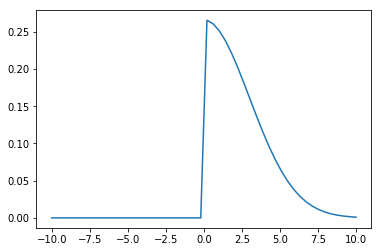

In [5]:
x = np.linspace(-10,10)
plt.plot(x, halfnorm(loc=0, scale = 3).pdf(x))

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

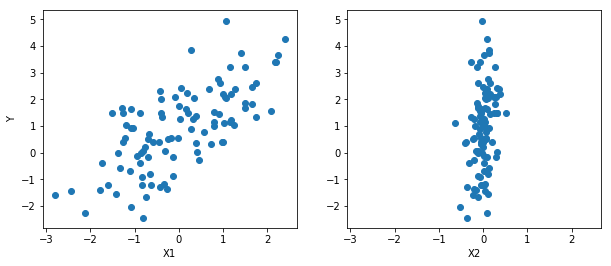

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

# Model specification

In [8]:
import pymc3 as pm

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

# Model fitting

In [11]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 803.08it/s]  


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma': array(0.96298858),
 'sigma_log__': array(-0.03771373)}

In [12]:
from scipy import optimize

map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)

map_estimate

/usr/local/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -149.47:   4%|▎         | 176/5000 [00:00<00:02, 1630.04it/s]

Optimization terminated successfully.
         Current function value: 148.984564
         Iterations: 4
         Function evaluations: 176


{'alpha': array(0.90907964),
 'beta': array([0.9514399 , 2.61452795]),
 'sigma': array(0.96568062),
 'sigma_log__': array(-0.03492212)}

# Sampling methods

To conduct MCMC sampling to generate posterior samples in PyMC3, we specify a step method object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3’s step_methods submodule contains the following samplers: NUTS, Metropolis, Slice, HamiltonianMC, and BinaryMetropolis. These step methods can be assigned manually, or assigned automatically by PyMC3. Auto-assignment is based on the attributes of each variable in the model. In general:

- Binary variables will be assigned to BinaryMetropolis
- Discrete variables will be assigned to Metropolis
- Continuous variables will be assigned to NUTS

In [13]:
from scipy import optimize

with basic_model:
    # draw 500 posterior samples
    trace = pm.sample()

/usr/local/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1000/1000 [00:01<00:00, 569.52it/s]


The sample function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns a ``Trace`` object containing the samples collected, in the order they were collected. The trace object can be queried in a similar way to a dict containing a map from variable names to numpy.arrays. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the alpha variable as follows:

In [17]:
trace['alpha'][-5:]

array([0.91876292, 0.87876941, 0.95650758, 0.94203069, 1.02499282])

In [18]:
with basic_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, start=start)

/usr/local/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -149.47:   4%|▎         | 176/5000 [00:00<00:02, 1617.74it/s]


Optimization terminated successfully.
         Current function value: 148.984564
         Iterations: 4
         Function evaluations: 176


100%|██████████| 5500/5500 [00:15<00:00, 354.04it/s]


# Posterior analysis

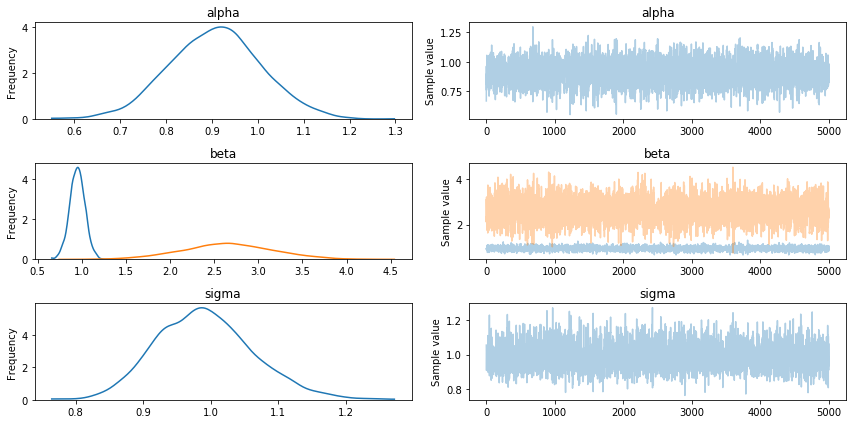

In [19]:
_ = pm.traceplot(trace)



The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.



In [20]:
pm.summary(trace)



alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.906            0.100            0.001            [0.717, 1.109]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.709          0.839          0.907          0.971          1.102


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.948            0.086            0.001            [0.766, 1.110]
  2.655            0.514            0.008            [1.646, 3.670]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.775          0.891          0.948          1.005          1.120
  1.647          2.322          2.653   